In [13]:
import random
import copy
import numpy as np
from itertools import combinations
from enum import Enum
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# 全局绘图样式优化
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'DejaVu Sans',
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold'
})

# -------------------- Game Definition --------------------
class Action(Enum):
    FOLD = 0
    CALL = 1
    RAISE = 2

class Stage(Enum):
    PREFLOP = 0
    FLOP = 1
    TURN = 2
    RIVER = 3
    SHOWDOWN = 4

class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
    def __repr__(self):
        return f"{self.rank}{self.suit}"

def create_deck():
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']
    deck = [Card(r,s) for r in ranks for s in suits]
    random.shuffle(deck)
    return deck

order = {'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'T':10,'J':11,'Q':12,'K':13,'A':14}
def card_value(c): return order[c.rank]

def check_straight(vals):
    vals = sorted(set(vals))
    if len(vals) < 5:
        return False, None
    for i in range(len(vals)-4):
        window = vals[i:i+5]
        if window[-1] - window[0] == 4:
            return True, window[-1]
    if {14,2,3,4,5}.issubset(vals):
        return True, 5
    return False, None

def evaluate_5card_hand(cards):
    vals = sorted([card_value(c) for c in cards], reverse=True)
    suits = [c.suit for c in cards]
    flush = len(set(suits)) == 1
    straight, high = check_straight(vals)
    freq = {v: vals.count(v) for v in vals}
    freq_sorted = sorted(freq.items(), key=lambda x:(x[1], x[0]), reverse=True)
    if flush and straight: return (8, high)
    if freq_sorted[0][1] == 4:
        four = freq_sorted[0][0]
        kick = max(v for v in vals if v != four)
        return (7, four, kick)
    if freq_sorted[0][1] == 3 and len(freq_sorted)>1 and freq_sorted[1][1]>=2:
        return (6, freq_sorted[0][0], freq_sorted[1][0])
    if flush: return (5, tuple(vals))
    if straight: return (4, high)
    if freq_sorted[0][1] == 3:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (3, freq_sorted[0][0], tuple(kickers))
    if len(freq_sorted)>=2 and freq_sorted[0][1]==2 and freq_sorted[1][1]==2:
        p1,p2 = freq_sorted[0][0], freq_sorted[1][0]
        kick = max(v for v in vals if v not in (p1,p2))
        return (2, max(p1,p2), min(p1,p2), kick)
    if freq_sorted[0][1] == 2:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (1, freq_sorted[0][0], tuple(kickers))
    return (0, tuple(vals))

def evaluate_hand(hole, community):
    best = (-1,)
    for combo in combinations(hole+community, 5):
        rank = evaluate_5card_hand(combo)
        if rank > best: best = rank
    return best

class PokerGame:
    def __init__(self, agents):
        assert len(agents)==2, "Head-to-head requires exactly 2 agents"
        self.agents = agents
        self.stacks = [500 for _ in agents]
        self.active = [True for _ in agents]
        self.deck = []
        self.hole_cards = [[] for _ in agents]
        self.community = []
    def reset(self):
        self.deck = create_deck()
        self.community = []
        self.hole_cards = [[self.deck.pop(), self.deck.pop()] for _ in self.agents]
        self.active = [True for _ in self.agents]
    def deal_community(self, num):
        for _ in range(num): self.community.append(self.deck.pop())
    def showdown(self):
        hands = [evaluate_hand(h, self.community) if self.active[i] else (-1,) for i,h in enumerate(self.hole_cards)]
        return max(range(len(hands)), key=lambda i: hands[i])
    def play_round(self):
        self.reset(); pot = 0; folded = [False, False]
        for deals in [0,3,1,1]:
            if deals: self.deal_community(deals)
            for i, agent in enumerate(self.agents):
                if not folded[i] and self.active[i]:
                    action = agent.act(self.hole_cards[i], self.community)
                    if action == Action.FOLD:
                        folded[i] = True
                    elif self.stacks[i]>=1:
                        self.stacks[i] -= 1; pot += 1
                    else:
                        folded[i] = True
        alive = [i for i in range(2) if not folded[i] and self.active[i]]
        winner = alive[0] if len(alive)==1 else (self.showdown() if len(alive)==2 else None)
        if winner is None: return [0,0]
        self.stacks[winner] += pot
        for i in range(2):
            if self.stacks[i]<=0: self.active[i]=False
        return [self.stacks[0], self.stacks[1]]

# -------------------- Agents --------------------
class RandomAgent:
    def act(self, hole, community): return random.choice(list(Action))

class EquityAgent:
    def act(self, hole, community):
        if len(community) < 5: return Action.CALL
        eq = self.estimate_equity(hole, community)
        return Action.RAISE if eq>0.6 else (Action.CALL if eq>0.4 else Action.FOLD)
    def estimate_equity(self, hole, community, sims=20):
        wins = 0
        for _ in range(sims):
            deck = create_deck(); known = hole+community
            deck = [c for c in deck if c not in known]
            opp = [deck.pop(), deck.pop()]
            full = community + [deck.pop() for _ in range(5-len(community))]
            if evaluate_hand(hole, full) > evaluate_hand(opp, full): wins+=1
        return wins/sims

class CFRAgent:
    def __init__(self, lr=0.1):
        self.regret_sum = {a:0.0 for a in Action}
        self.lr = lr
    def get_strategy(self):
        pos = [max(r,0) for r in self.regret_sum.values()]
        total = sum(pos)
        return {a: (max(self.regret_sum[a],0)/total if total>0 else 1/3) for a in Action}
    def act(self, hole, community):
        strat = self.get_strategy()
        return random.choices(list(strat), list(strat.values()))[0]
    def train(self):
        strat = self.get_strategy()
        util = {a: (1 if a==Action.RAISE else (0 if a==Action.CALL else -1)) for a in Action}
        node_util = sum(strat[a]*util[a] for a in Action)
        for a in Action:
            # 学习率加权更新 regrets
            self.regret_sum[a] += self.lr * (util[a] - node_util)

# -------------------- DQN Agent --------------------
def encode_state(hole, community):
    vals = [card_value(c) for c in hole]
    comm = [card_value(c) for c in community] + [0]*(5-len(community))
    return np.array(vals+comm, dtype=np.float32)/14.0

class DQNAgent:
    def __init__(self, state_size=7, action_size=3, lr=5e-4):
        self.state_size, self.action_size = state_size, action_size
        self.epsilon, self.epsilon_decay, self.epsilon_min = 1.0, 0.99, 0.05
        self.gamma, self.batch_size = 0.98, 32
        self.memory = deque(maxlen=20000)
        self.model = nn.Sequential(
            nn.Linear(state_size,128), nn.ReLU(),
            nn.Linear(128,64), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64,action_size)
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
    def act(self, hole, community):
        state = torch.tensor(encode_state(hole, community)).unsqueeze(0)
        if random.random() < self.epsilon:
            return random.choice(list(Action))
        with torch.no_grad(): q = self.model(state).numpy().flatten()
        return Action(int(np.argmax(q)))
    def remember(self, s,a,r,ns,d): self.memory.append((s,a.value,r,ns,d))
    def replay(self):
        if len(self.memory) < self.batch_size: return
        batch = random.sample(self.memory, self.batch_size)
        s,a,r,ns,done = zip(*batch)
        s = torch.tensor(s); a = torch.tensor(a); r = torch.tensor(r)
        ns = torch.tensor(ns); done = torch.tensor(done, dtype=torch.float32)
        q_next = self.model(ns).detach().max(1)[0]
        q_target = r + self.gamma*q_next*(1-done)
        q_vals = self.model(s).gather(1, a.unsqueeze(1)).squeeze()
        loss = self.loss_fn(q_vals, q_target)
        self.optimizer.zero_grad(); loss.backward(); self.optimizer.step()
        if self.epsilon > self.epsilon_min: self.epsilon *= self.epsilon_decay

# -------------------- Training Functions --------------------
def train_dqn(agent, opponent, episodes=1000):
    env = PokerGame([agent, opponent])
    for _ in range(episodes):
        env.reset()
        hole, comm = env.hole_cards[0], env.community
        state = encode_state(hole, comm)
        action = agent.act(hole, comm)
        prev = env.stacks[0]
        stacks = env.play_round()
        reward = stacks[0] - prev
        next_state = np.zeros(agent.state_size, dtype=np.float32)
        agent.remember(state, action, reward, next_state, True)
        agent.replay()
    return agent

# -------------------- Pairwise Simulation --------------------
def simulate_pair(agent1, agent2, hands=200, cfr_iters=50):
    game = PokerGame([agent1, agent2])
    records = [[], []]
    for _ in range(hands):
        if isinstance(agent1, CFRAgent):
            for __ in range(cfr_iters): agent1.train()
        if isinstance(agent2, CFRAgent):
            for __ in range(cfr_iters): agent2.train()
        prev = game.stacks.copy()
        stacks = game.play_round()
        records[0].append(stacks[0])
        records[1].append(stacks[1])
    return records



Pre-training DQN vs RandomAgent...


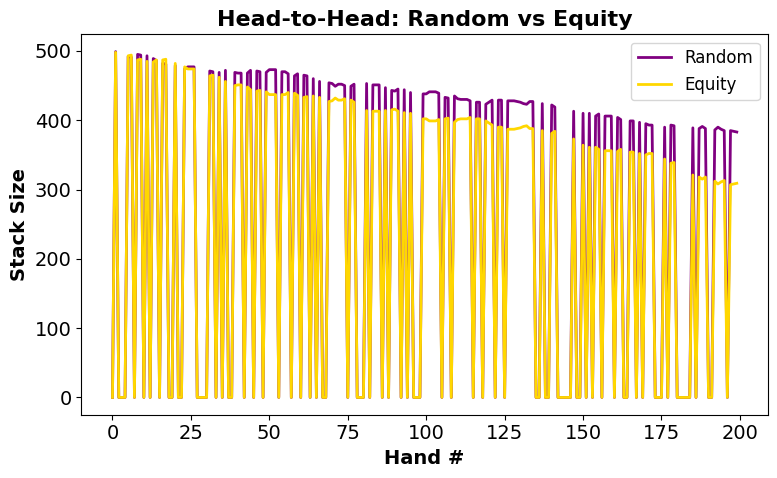

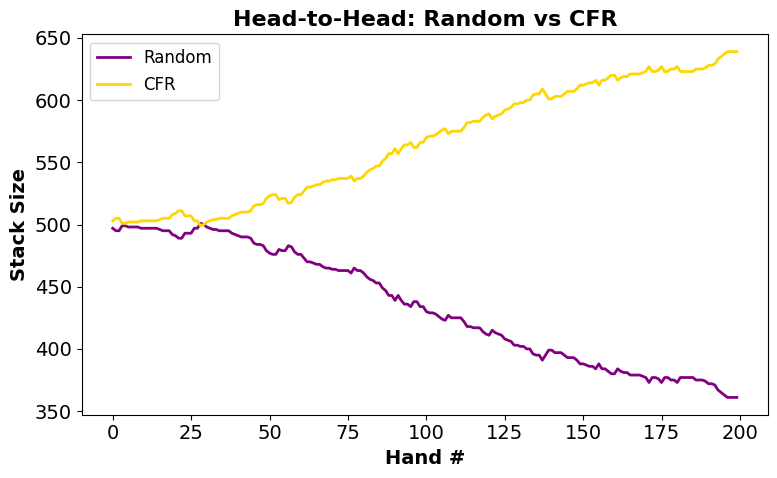

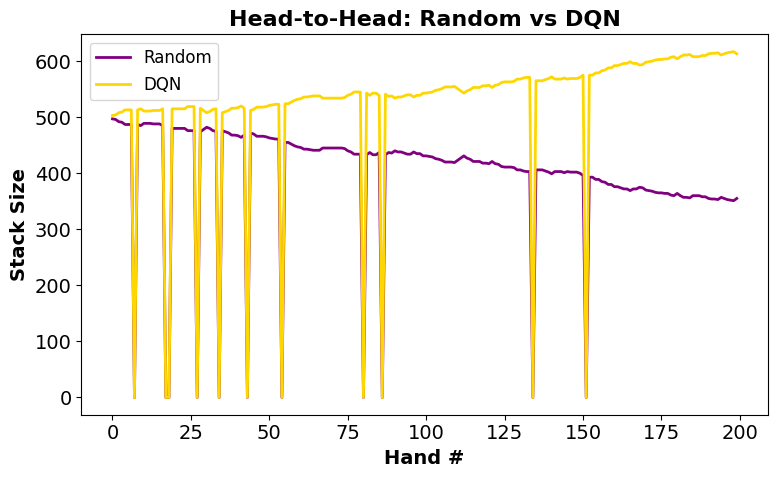

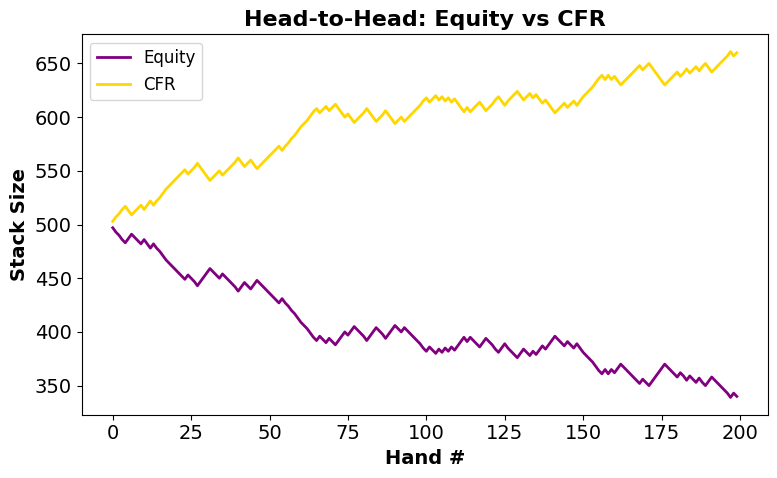

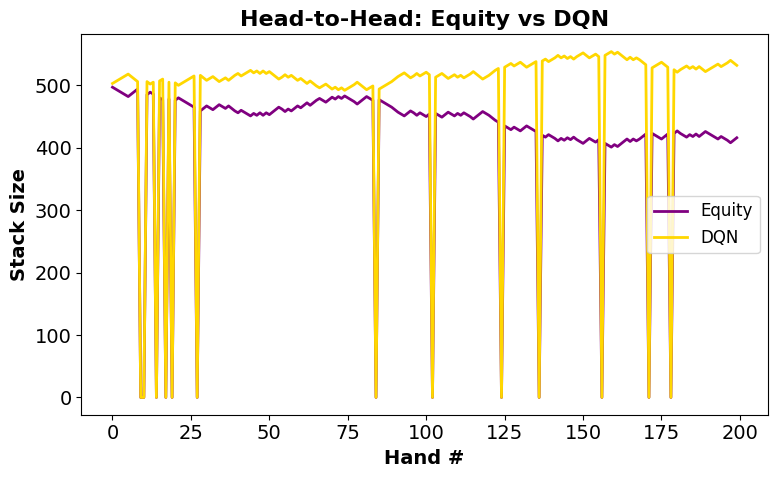

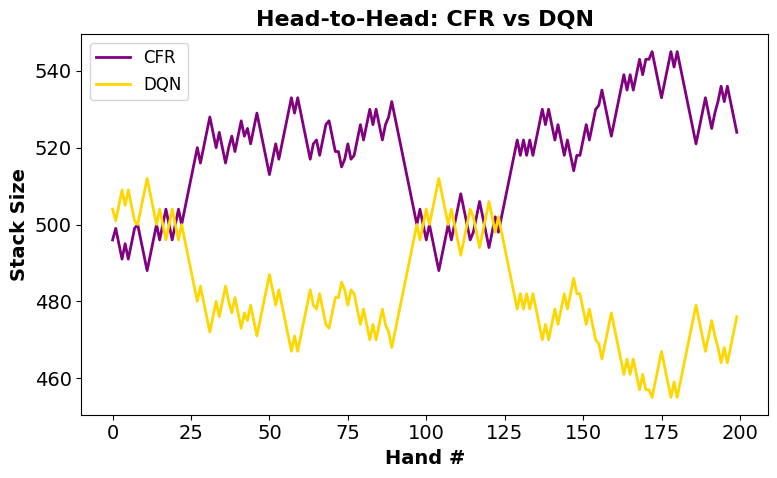

In [14]:
# -------------------- Main --------------------
if __name__ == "__main__":
    agents = [RandomAgent(), EquityAgent(), CFRAgent(lr=0.2), DQNAgent()]
    names = ['Random','Equity','CFR','DQN']
    print("Pre-training DQN vs RandomAgent...")
    agents[3] = train_dqn(agents[3], RandomAgent(), episodes=1000)
    pairings = list(combinations(range(len(agents)), 2))
    for (i,j) in pairings:
        rec = simulate_pair(agents[i], agents[j], hands=200)
        plt.figure(figsize=(8,5))
        plt.plot(rec[0], label=names[i], color='purple', linewidth=2)
        plt.plot(rec[1], label=names[j], color='gold', linewidth=2)
        plt.title(f"Head-to-Head: {names[i]} vs {names[j]}", fontsize=16)
        plt.xlabel("Hand #", fontsize=14)
        plt.ylabel("Stack Size", fontsize=14)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()